In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [38]:
df = pd.read_csv("../data/Telco-Customer-Churn.csv")

In [39]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [40]:
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
serv_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
multi_cols = ['InternetService', 'Contract', 'PaymentMethod']

for col in binary_cols:
    if col == 'gender':
        df[col] = df[col].map({'Female': 0, 'Male': 1})
    else:
        df[col] = df[col].map({'No': 0, 'Yes': 1})

for col in serv_cols:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})
    df[col] = df[col].map({'No': 0, 'Yes': 1})

df = pd.get_dummies(df, columns=multi_cols, drop_first=True, dtype=int)

df.drop('customerID', axis=1, inplace=True)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [41]:
Y = df.pop("Churn").to_numpy()
X = df.to_numpy()

np.random.seed(42)

indices = np.arange(X.shape[0])
np.random.shuffle(indices)

split_limit = int(0.8 * len(X))
train_idx, test_idx = indices[:split_limit], indices[split_limit:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = Y[train_idx], Y[test_idx]

In [42]:
Xmean_train = np.mean(X_train, axis=0)
Xdev_train = np.std(X_train, axis=0)

x_train = (X_train - Xmean_train) / (Xdev_train + 1e-8)
x_test = (X_test - Xmean_train) / (Xdev_train + 1e-8)

In [43]:
def predict(X,w,b):
  z = np.dot(X,w) + b
  return 1 / (1 + np.exp(-z))

In [44]:
def classify(probabilities, threshold=0.5):
    return (probabilities >= threshold).astype(int)

In [45]:
def compute_cost(X,Y,w,b, lambda_=0.1):
  m = X.shape[0]
  epsilon = 1e-15

  y_hat = predict(X, w, b)
  y_hat = np.clip(y_hat, epsilon, 1 - epsilon)

  cost = - (1/m) * np.sum(Y * np.log(y_hat) + (1 - Y) * np.log(1 - y_hat))

  reg_cost = (lambda_ / (2 * m)) * np.sum(np.square(w))

  total_cost = cost + reg_cost

  return total_cost

In [46]:
def compute_gradient(X,Y,w,b, lambda_=0.1):
  m = X.shape[0]
  y_hat = predict(X,w,b)
  error = y_hat - Y
  dj_dw = (1/m) * np.dot(X.T, error)
  dj_db = (1/m) * np.sum(error)
  dj_dw_reg = (lambda_ / m) * w
  dj_dw = dj_dw + dj_dw_reg
  return dj_dw, dj_db

In [47]:
def gradient_descent(X,Y, epoches=1000, rate=0.1, lambda_=0.1):
  m,n = X.shape
  w = np.zeros(n)
  cost_history = np.zeros(epoches)
  b = 0
  for i in range(epoches):
    cost_history[i] = compute_cost(X,Y,w,b,lambda_)
    if i % 100 == 0:
      print(f"Epoch {i}: {cost_history[i]}")
    dj_dw, dj_db = compute_gradient(X,Y,w,b,lambda_)
    w -= rate*dj_dw
    b -= rate*dj_db
  return w, b, cost_history

In [48]:
epoches = 1000
rate = 0.1
w, b, cost_history = gradient_descent(x_train, y_train, epoches, rate , 0.1)

Epoch 0: 0.6931471805599453
Epoch 100: 0.43213007050451435
Epoch 200: 0.42109037477753264
Epoch 300: 0.4188285860132279
Epoch 400: 0.4180446461743219
Epoch 500: 0.41765017928357123
Epoch 600: 0.417394824874452
Epoch 700: 0.4172035363843025
Epoch 800: 0.41704828395505006
Epoch 900: 0.41691634928571586


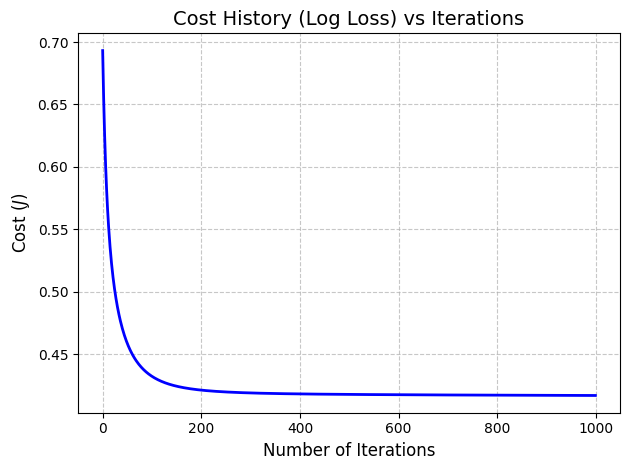

In [49]:
plt.plot(np.arange(0,1000), cost_history, color='blue', linewidth=2)
plt.title('Cost History (Log Loss) vs Iterations', fontsize=14)
plt.xlabel('Number of Iterations', fontsize=12)
plt.ylabel('Cost ($J$)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('cost_history_plot.png')

In [50]:
def calculate_f1(test_preds, y_test):
    tp = np.sum((test_preds == 1) & (y_test == 1))
    fp = np.sum((test_preds == 1) & (y_test == 0))
    fn = np.sum((test_preds == 0) & (y_test == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    if (precision + recall) == 0:
        return 0.0
    return (2 * precision * recall) / (precision + recall)

In [51]:
test_probs = predict(x_test, w, b)
test_preds = classify(test_probs, 0.5)

accuracy = np.mean(test_preds == y_test)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"F1 Score: {calculate_f1(test_preds, y_test)}")

Test Accuracy: 80.48%
F1 Score: 0.5723172628304821


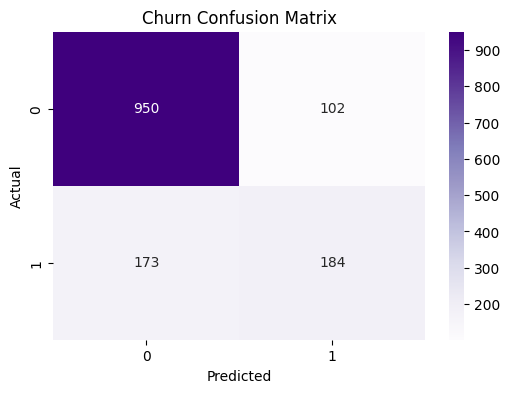

In [52]:
cm = confusion_matrix(y_test, test_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Churn Confusion Matrix')
plt.show()

In [53]:
best_threshold = 0
max_f1 = 0
thresholds = np.linspace(0.05, 0.95, 19)

for threshold in thresholds:
  test_preds = classify(test_probs, threshold)
  f1_score = calculate_f1(test_preds, y_test)
  if (f1_score > max_f1):
    max_f1 = f1_score
    best_threshold = threshold
  threshold += 0.05
print(f"Best threshold is {best_threshold}")
test_preds = classify(test_probs, best_threshold)
accuracy = np.mean(test_preds == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
f1_score = calculate_f1(test_preds, y_test)
print(f"F1 Score: {f1_score}\n")


Best threshold is 0.35
Test Accuracy: 77.50%
F1 Score: 0.605230386052304



In [54]:
feature_names = df.columns

importance = pd.DataFrame({'Feature': feature_names, 'Weight': w})
print(importance.sort_values(by='Weight', ascending=False).head(5).to_string(index=False))

                       Feature   Weight
   InternetService_Fiber optic 0.373236
                MonthlyCharges 0.198168
PaymentMethod_Electronic check 0.183936
              PaperlessBilling 0.141539
                 MultipleLines 0.131241
